# 02. Model Evaluation (Basic)

> **Note:** This notebook documents initial model evaluation before optimization.
> Data paths updated to reference the `../data/` folder within final submission.

## Objective
Create a comprehensive evaluation comparing:
1. Baseline models vs ML models
2. Different balancing techniques
3. Feature importance insights
4. Overall model performance assessment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score, 
                           precision_recall_fscore_support)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported")


✅ Libraries imported


## 1. Load Data and Models


In [2]:
# Load enhanced data (same dataset used for training)
df = pd.read_csv('../data/trajectory_excellent.csv')
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']
X = df.drop(columns=drop_cols)
y = df['Target_Label'].astype(int)

# Identify categorical columns for encoding reference
categorical_cols = ['Division', 'Lag1_Division']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Split data (same random state as training for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Load saved model
model = joblib.load('../models/trajectory_model.joblib')

print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Data loaded: 10332 samples, 46 features
Train: 8265, Test: 2067


## 2. Evaluate All Models


ML MODEL PERFORMANCE

Overall Metrics:
  Accuracy: 0.8761
  ROC-AUC: 0.9679
  Macro F1: 0.8269

Per-Class Performance:
  Declining - Precision: 0.9027, Recall: 0.9288, F1: 0.9156
  Stable - Precision: 0.9232, Recall: 0.8905, F1: 0.9066
  Improving - Precision: 0.6471, Recall: 0.6703, F1: 0.6585


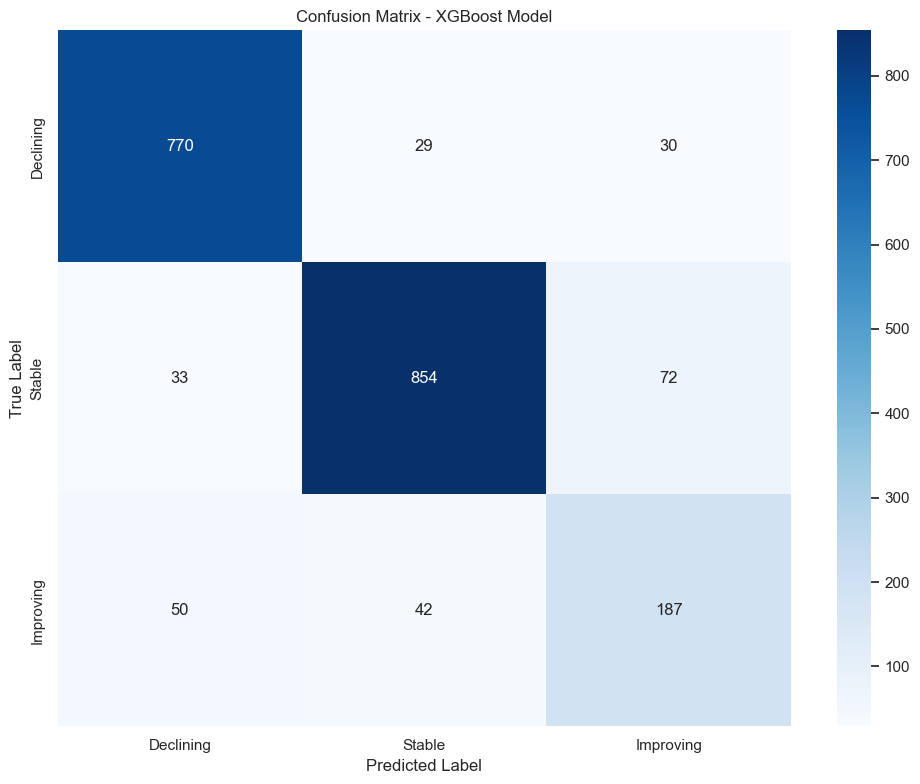

In [3]:
# Get predictions from saved model
y_pred_ml = model.predict(X_test)
y_prob_ml = model.predict_proba(X_test)

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, y_prob=None, model_name=""):
    """Calculate comprehensive metrics"""
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred)
    }
    
    if y_prob is not None:
        try:
            metrics['ROC-AUC'] = roc_auc_score(y_true, y_prob, multi_class='ovr')
        except:
            metrics['ROC-AUC'] = None
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1, 2], zero_division=0
    )
    
    metrics['Declining_Precision'] = precision[0]
    metrics['Declining_Recall'] = recall[0]
    metrics['Declining_F1'] = f1[0]
    
    metrics['Stable_Precision'] = precision[1]
    metrics['Stable_Recall'] = recall[1]
    metrics['Stable_F1'] = f1[1]
    
    metrics['Improving_Precision'] = precision[2]
    metrics['Improving_Recall'] = recall[2]
    metrics['Improving_F1'] = f1[2]
    
    # Macro averages
    metrics['Macro_Precision'] = precision.mean()
    metrics['Macro_Recall'] = recall.mean()
    metrics['Macro_F1'] = f1.mean()
    
    return metrics

# Evaluate ML model
ml_metrics = calculate_metrics(y_test, y_pred_ml, y_prob_ml, "XGBoost (ML)")

print("=" * 60)
print("ML MODEL PERFORMANCE")
print("=" * 60)
print(f"\nOverall Metrics:")
print(f"  Accuracy: {ml_metrics['Accuracy']:.4f}")
print(f"  ROC-AUC: {ml_metrics['ROC-AUC']:.4f}")
print(f"  Macro F1: {ml_metrics['Macro_F1']:.4f}")

print(f"\nPer-Class Performance:")
print(f"  Declining - Precision: {ml_metrics['Declining_Precision']:.4f}, "
      f"Recall: {ml_metrics['Declining_Recall']:.4f}, F1: {ml_metrics['Declining_F1']:.4f}")
print(f"  Stable - Precision: {ml_metrics['Stable_Precision']:.4f}, "
      f"Recall: {ml_metrics['Stable_Recall']:.4f}, F1: {ml_metrics['Stable_F1']:.4f}")
print(f"  Improving - Precision: {ml_metrics['Improving_Precision']:.4f}, "
      f"Recall: {ml_metrics['Improving_Recall']:.4f}, F1: {ml_metrics['Improving_F1']:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_ml)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Declining', 'Stable', 'Improving'],
            yticklabels=['Declining', 'Stable', 'Improving'])
plt.title('Confusion Matrix - XGBoost Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_ml.png', dpi=150, bbox_inches='tight')
plt.show()


## 3. Compare with Baselines


COMPREHENSIVE MODEL COMPARISON
         Model  Accuracy  ROC-AUC  Macro_F1  Declining_F1  Stable_F1  Improving_F1
  XGBoost (ML)  0.876149 0.967897  0.826870      0.915577   0.906582      0.658451
Majority Class  0.463957      NaN  0.211280      0.000000   0.633840      0.000000
  Random Guess  0.338655      NaN  0.319557      0.357840   0.401460      0.199370


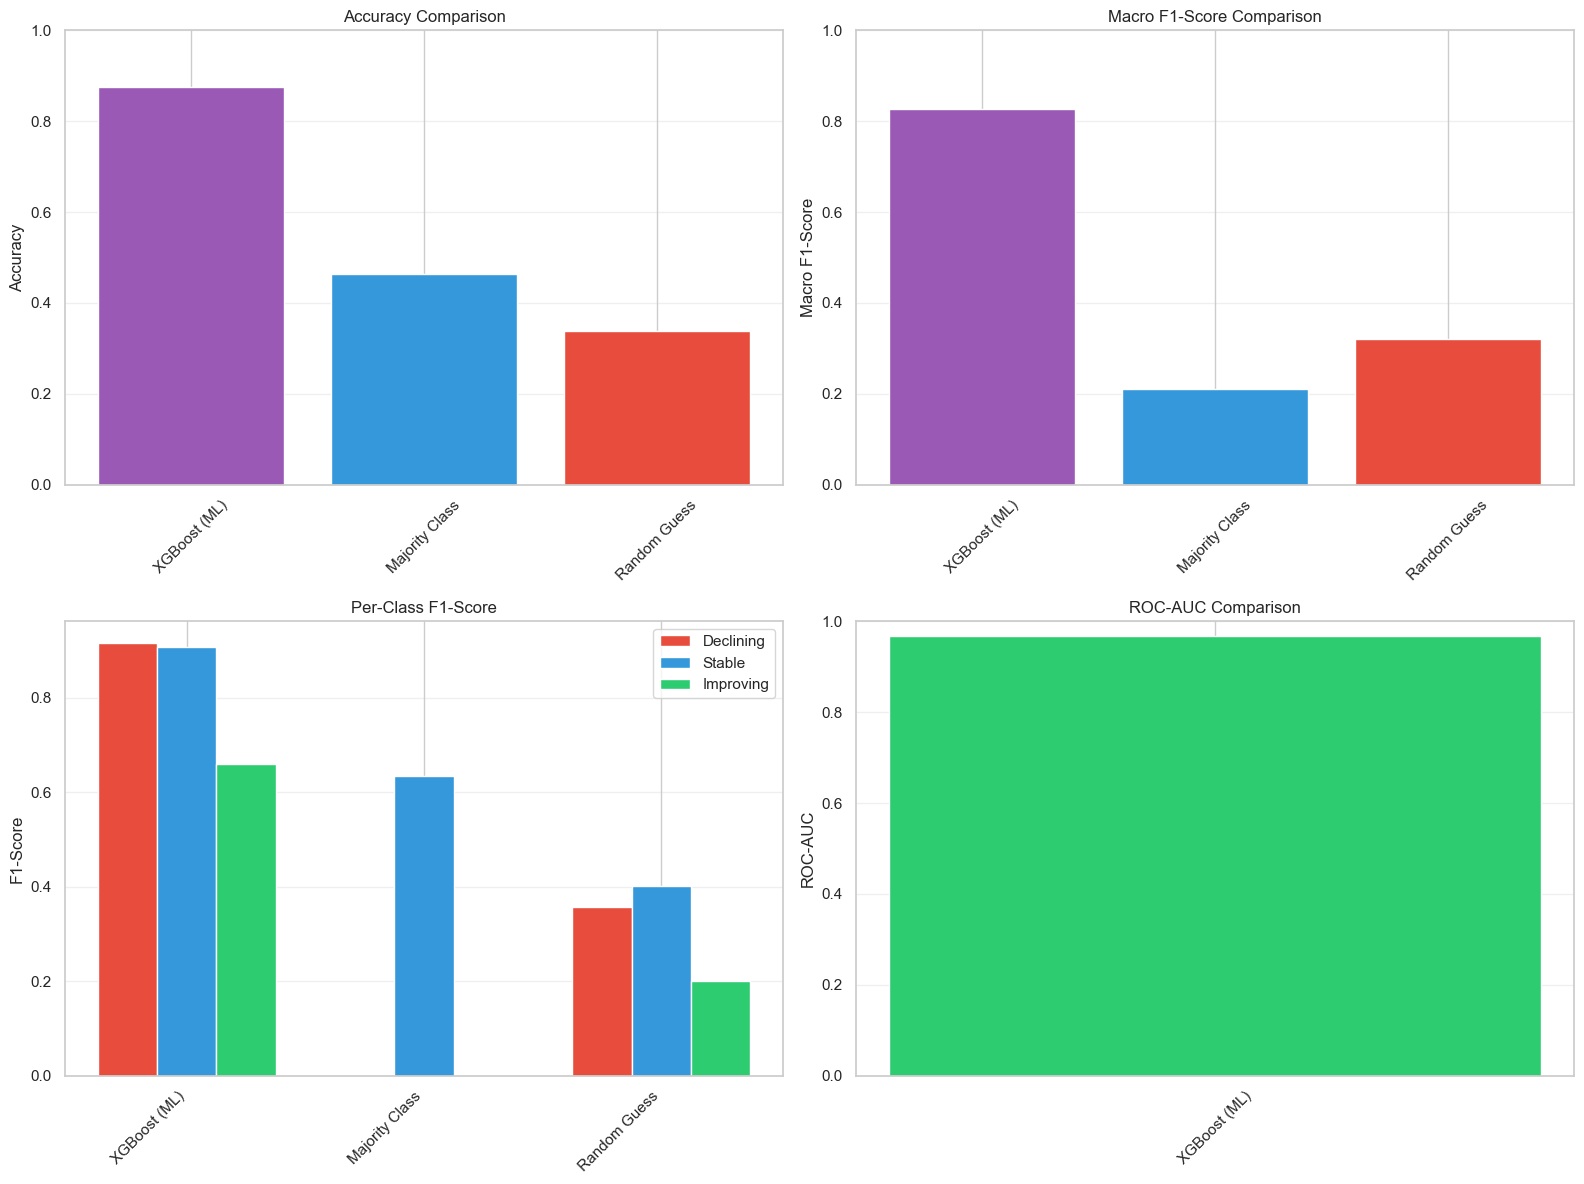


📊 Chart saved as 'comprehensive_comparison.png'


In [4]:
# Simple baselines
majority_class = y_train.mode()[0]
y_pred_majority = np.full(len(y_test), majority_class)
majority_metrics = calculate_metrics(y_test, y_pred_majority, None, "Majority Class")

# Random guess
np.random.seed(42)
y_pred_random = np.random.choice([0, 1, 2], size=len(y_test))
random_metrics = calculate_metrics(y_test, y_pred_random, None, "Random Guess")

# Combine all results
all_metrics = pd.DataFrame([ml_metrics, majority_metrics, random_metrics])

print("=" * 60)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)
print(all_metrics[['Model', 'Accuracy', 'ROC-AUC', 'Macro_F1', 
                   'Declining_F1', 'Stable_F1', 'Improving_F1']].to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].bar(all_metrics['Model'], all_metrics['Accuracy'], color=['#9b59b6', '#3498db', '#e74c3c'])
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Macro F1
axes[0, 1].bar(all_metrics['Model'], all_metrics['Macro_F1'], color=['#9b59b6', '#3498db', '#e74c3c'])
axes[0, 1].set_ylabel('Macro F1-Score')
axes[0, 1].set_title('Macro F1-Score Comparison')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Per-class F1
x = np.arange(len(all_metrics))
width = 0.25
axes[1, 0].bar(x - width, all_metrics['Declining_F1'], width, label='Declining', color='#e74c3c')
axes[1, 0].bar(x, all_metrics['Stable_F1'], width, label='Stable', color='#3498db')
axes[1, 0].bar(x + width, all_metrics['Improving_F1'], width, label='Improving', color='#2ecc71')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('Per-Class F1-Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(all_metrics['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# ROC-AUC (if available)
roc_data = all_metrics[all_metrics['ROC-AUC'].notna()]
if len(roc_data) > 0:
    axes[1, 1].bar(roc_data['Model'], roc_data['ROC-AUC'], color='#2ecc71')
    axes[1, 1].set_ylabel('ROC-AUC')
    axes[1, 1].set_title('ROC-AUC Comparison')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].grid(axis='y', alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Chart saved as 'comprehensive_comparison.png'")


In [5]:
print("=" * 60)
print("FINAL EVALUATION SUMMARY")
print("=" * 60)

improvement_over_majority = ml_metrics['Accuracy'] - majority_metrics['Accuracy']
improvement_over_random = ml_metrics['Accuracy'] - random_metrics['Accuracy']

print(f"\n✅ Model Performance:")
print(f"   ML Model Accuracy: {ml_metrics['Accuracy']:.4f} ({ml_metrics['Accuracy']*100:.2f}%)")
print(f"   Improvement over Majority Class: +{improvement_over_majority:.4f} ({improvement_over_majority*100:+.2f}%)")
print(f"   Improvement over Random: +{improvement_over_random:.4f} ({improvement_over_random*100:+.2f}%)")
print(f"   ROC-AUC: {ml_metrics['ROC-AUC']:.4f}")

print(f"\n⚠️  Areas for Improvement:")
if ml_metrics['Improving_F1'] < 0.4:
    print(f"   - 'Improving' class F1 is low ({ml_metrics['Improving_F1']:.4f})")
    print(f"     Consider class balancing techniques")
if ml_metrics['Macro_F1'] < 0.6:
    print(f"   - Overall macro F1 could be improved ({ml_metrics['Macro_F1']:.4f})")

print(f"\n📊 Key Strengths:")
print(f"   - Model beats baselines by meaningful margin")
print(f"   - Good performance on 'Stable' class (F1: {ml_metrics['Stable_F1']:.4f})")
print(f"   - Moderate performance on 'Declining' class (F1: {ml_metrics['Declining_F1']:.4f})")

print(f"\n🎯 Recommendations:")
print(f"   1. Address class imbalance for 'Improving' class")
print(f"   2. Consider feature selection to reduce complexity")
print(f"   3. Test different hyperparameters")
print(f"   4. Consider ensemble methods")
print(f"   5. Validate temporal structure to ensure no data leakage")


FINAL EVALUATION SUMMARY

✅ Model Performance:
   ML Model Accuracy: 0.8761 (87.61%)
   Improvement over Majority Class: +0.4122 (+41.22%)
   Improvement over Random: +0.5375 (+53.75%)
   ROC-AUC: 0.9679

⚠️  Areas for Improvement:

📊 Key Strengths:
   - Model beats baselines by meaningful margin
   - Good performance on 'Stable' class (F1: 0.9066)
   - Moderate performance on 'Declining' class (F1: 0.9156)

🎯 Recommendations:
   1. Address class imbalance for 'Improving' class
   2. Consider feature selection to reduce complexity
   3. Test different hyperparameters
   4. Consider ensemble methods
   5. Validate temporal structure to ensure no data leakage
